## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
#為了解決 model.fit 當掉問題
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization
"""Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128, 64]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)


In [11]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
__________

50000/50000 [==============================] - 16s 312us/step - loss: 0.9028 - acc: 0.6915 - val_loss: 1.5186 - val_acc: 0.4878
Epoch 48/50
50000/50000 [==============================] - 16s 318us/step - loss: 0.8913 - acc: 0.6943 - val_loss: 1.5295 - val_acc: 0.4859
Epoch 49/50
50000/50000 [==============================] - 16s 313us/step - loss: 0.8793 - acc: 0.7020 - val_loss: 1.5277 - val_acc: 0.4806
Epoch 50/50
10000/10000 [==============================] - 4s 378us/step


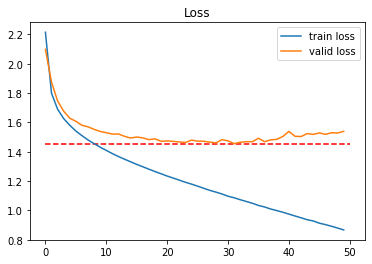

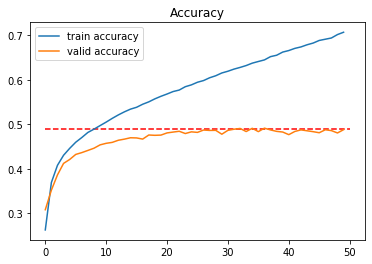

In [12]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

### HW : Save/Load model
https://morvanzhou.github.io/tutorials/machine-learning/keras/3-1-save/

In [13]:
# save
print('test before save: ', model.predict(x_test[0:2]))
model.save('my_model.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
del model  # deletes the existing model


test before save:  [[1.3725031e-02 1.5428724e-02 1.2869481e-02 8.7412047e-01 6.4847143e-03
  3.1401999e-02 3.3360146e-02 2.5649439e-03 9.6766418e-03 3.6798281e-04]
 [2.7238596e-02 6.0035225e-02 4.8705530e-03 2.3232850e-03 1.4064383e-03
  1.7708255e-03 1.6394641e-03 1.1810086e-03 7.2778261e-01 1.7175199e-01]]


In [15]:
# load
from keras.models import load_model 

model = load_model('my_model.h5')
print('test after load: ', model.predict(x_test[0:2]))


test after load:  [[1.3725031e-02 1.5428724e-02 1.2869481e-02 8.7412047e-01 6.4847143e-03
  3.1401999e-02 3.3360146e-02 2.5649439e-03 9.6766418e-03 3.6798281e-04]
 [2.7238596e-02 6.0035225e-02 4.8705530e-03 2.3232850e-03 1.4064383e-03
  1.7708255e-03 1.6394641e-03 1.1810086e-03 7.2778261e-01 1.7175199e-01]]


In [16]:
# save and load weights
model.save_weights('my_model_weights.h5')
model.load_weights('my_model_weights.h5')

In [17]:
# save and load fresh network without trained weights
from keras.models import model_from_json
json_string = model.to_json()
model = model_from_json(json_string)